# Homework 2

## Sampled Softmax

### 1

$$\frac{\partial l}{\partial p_i} = - \frac{1}{\partial p_i} = - \frac{\sum_{j=1}^Ce^{z_j}}{{e^{z_i}}}$$

$$\frac{\partial p_i}{\partial z_i} = \frac{e^{z_i}\sum_{j=1}^Ce^{z_j} - e^{z_i}e^{z_i}}{(\sum_{j=1}^Ce^{z_j})^2}$$

Then

$$\frac{\partial l}{\partial z_i} = - \frac{\partial l}{\partial p_i} \frac{\partial p_i}{\partial z_i} = - \frac{\sum_{j=1}^Ce^{z_j}}{{e^{z_i}}} \frac{e^{z_i}\sum_{j=1}^Ce^{z_j} - e^{z_i}e^{z_i}}{(\sum_{j=1}^Ce^{z_j})^2} = -\frac{\sum_{j=1}^Ce^{z_j} - e^{z_i}}{\sum_{j=1}^Ce^{z_j}} = -(1 - p_i) = p_i - 1$$

So

$\frac{\partial l}{\partial w_i} = \frac{\partial l}{\partial p_i} \frac{\partial p_i}{\partial z_i} \frac{\partial z_i}{\partial w_i} = (p_i - 1) x$


$\frac{\partial l}{\partial b_i} = \frac{\partial l}{\partial p_i} \frac{\partial p_i}{\partial z_i} \frac{\partial z_i}{\partial b_i} = (p_i - 1)$

### 2

Similarily, we have

$$\frac{\partial \hat l}{\partial \hat p_i} = - \frac{1}{\partial \hat p_i} = - \frac{e^{z_i} + \frac{1}{K}\sum_{j \in S} q_j e^{z_j}}{{e^{z_i}}}$$


$$\frac{\partial \hat p_i}{\partial z_i} = \frac{
    e^{z_i}(e^{z_i} + \frac{1}{K}\sum_{j \in S} q_j e^{z_j})
    - e^{z_i}(e^{z_i} + \frac{1}{K} \mathbf I(i \in S) q_i e^{z_i})
}{
    (e^{z_i} + \frac{1}{K}\sum_{j \in S} q_j e^{z_j})^2
}$$

Here $\mathbf I(i \in S)$ is the indicator function, which is 1 if $i \in S$ and 0 otherwise.

so

$$\frac{\partial \hat l}{\partial \hat z_i} = - \frac{\partial \hat l}{\partial \hat p_i} \frac{\partial \hat p_i}{\partial \hat z_i} = - \frac{e^{z_i} + \frac{1}{K}\sum_{j \in S} q_j e^{z_j}}{{e^{z_i}}} \frac{
    e^{z_i}(e^{z_i} + \frac{1}{K}\sum_{j \in S} q_j e^{z_j})
    - e^{z_i}(e^{z_i} + \frac{1}{K} \mathbf I(i \in S) q_i e^{z_i})
}{
    (e^{z_i} + \frac{1}{K}\sum_{j \in S} q_j e^{z_j})^2
}$$

$$ = - \frac{
    \frac{1}{K}\sum_{j \in S} q_j e^{z_j}
     - \frac{1}{K} \mathbf I(i \in S) q_i e^{z_i}
}{
    e^{z_i} + \frac{1}{K}\sum_{j \in S} q_j e^{z_j}
}$$

If $i \notin S$ then

$$ = - \frac{
    \frac{1}{K}\sum_{j \in S} q_j e^{z_j}
}{
    e^{z_i} + \frac{1}{K}\sum_{j \in S} q_j e^{z_j}
}= - (1 - \hat p_i) = \hat p_i - 1$$

Else

$$ = - \frac{
    \frac{1}{K}\sum_{j \in S} q_j e^{z_j}
     - \frac{1}{K} q_i e^{z_i}
}{
    e^{z_i} + \frac{1}{K}\sum_{j \in S} q_j e^{z_j}
}=  - \frac{
    \frac{1}{K}\sum_{j \in S} q_j e^{z_j} + e^{z_i} - e^{z_i}
     - \frac{1}{K} q_i e^{z_i}
}{
    e^{z_i} + \frac{1}{K}\sum_{j \in S} q_j e^{z_j}
} = -(1 - p_i - \frac{1}{K}q_ip_i) = (1 + \frac{1}{K})p_i - 1$$

Now

$\frac{\partial \hat l}{\partial w_i} = \frac{\partial \hat l}{\partial \hat p_i} \frac{\partial \hat p_i}{\partial \hat z_i} \frac{\partial \hat z_i}{\partial w_i} = (p_i - 1) x$ if $i \notin S$ else $\frac{\partial \hat l}{\partial w_i} = ((1 + \frac{1}{K})p_i - 1) x$


$\frac{\partial \hat l}{\partial b_i} = \frac{\partial \hat l}{\partial \hat p_i} \frac{\partial \hat p_i}{\partial \hat z_i} \frac{\partial \hat z_i}{\partial b_i} = (p_i - 1)$ if $i \notin S$ else $\frac{\partial \hat l}{\partial b_i} = ((1 + \frac{1}{K})p_i - 1)$



## Linear classifier v.s. MLP

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision import datasets

In [2]:
train_all = datasets.MNIST('./data', train =True , download = True, transform=transforms.ToTensor()) # train : 60K
train_data, val_data = torch.utils.data.random_split(
    train_all, [50000, 10000 ], torch.Generator().manual_seed(0)) # train : 50K ; val : 10K
test_data = datasets.MNIST('./data', train = False, transform=transforms.ToTensor() ) # test : 10K

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cpu


### 1

In [4]:
# build a 10-class softmax classifier on the images. Train the classifier via storchastic gradient
# descent, and report test accuracy.

class SoftmaxClassifier(nn.Module):

    def __init__(self, input_size, output_size):
        super(SoftmaxClassifier, self).__init__()
        self.l1 = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.l1(x)
        return F.log_softmax(x, dim=1)

In [16]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=512, shuffle=True)


def train_and_return_test_accuracy(network, epochs=30, lr=0.005):
    """Helper function, train the network on train set, and return test accuracy"""
    # train via storchastic gradient descent
    optimizer = optim.SGD(network.parameters(), lr=lr, momentum=0.9)
    loss_func = nn.CrossEntropyLoss()

    # train
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.view(-1, 28*28).to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = network(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch + 1, loss.item()))

    # compute test accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_data:
            data = data.view(-1, 28*28).to(device)
            target = target
            outputs = network(data)
            _, predicted = torch.max(outputs.data, 1)
            total += 1
            correct += (predicted == target).sum().item()
    test_accuracy = correct / total
    return test_accuracy

In [8]:
network = SoftmaxClassifier(784, 10).to(device)
test_accuracy = train_and_return_test_accuracy(network)
print(f'Test accuracy: {test_accuracy}')

Train Epoch: 10 	Loss: 0.329184
Train Epoch: 20 	Loss: 0.335898
Train Epoch: 30 	Loss: 0.312095
Test accuracy: 0.9147


### 2

In [9]:
# Insert one hidden layer with 1024 hidden units before the softmax classifier. And use ReLU as
# the activation function at the hidden layer. Train and report test accuracy.

class SoftmaxClassifier(nn.Module):

    def __init__(self, input_size, output_size):
        super(SoftmaxClassifier, self).__init__()
        self.l1 = nn.Linear(input_size, 1024)
        self.l2 = nn.Linear(1024, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return F.log_softmax(x, dim=1)

In [10]:
network = SoftmaxClassifier(784, 10).to(device)
test_accuracy = train_and_return_test_accuracy(network)
print(f'Test accuracy: {test_accuracy}')

Train Epoch: 10 	Loss: 0.262234
Train Epoch: 20 	Loss: 0.160454
Train Epoch: 30 	Loss: 0.184145
Test accuracy: 0.9452


### 3

Assuming each hiddent layer has k units

1. input to the first hidden, there are 785k parameters:
    - weight matrix: 28 * 28 * k
    - bias: k
2. next $L - 1$ hidden layers, there are $(k^2 + k)(L - 1)$ parameters in total, for each layer
    - weight matrix: $k * k$
    - bias: $k$
3. softmax layer, there are $k * 10 + 10$ parameters
    - weight matrix: $k * 10$
    - bias: 10

So in total there are $785k + (k^2 + k)(L - 1) + k * 10 + 10$ parameters.

$$785k + (k^2 + k)(L - 1) + k * 10 + 10 = 814090$$

We have $$(L - 1)k^2 + (794 + L)k - 814080 = 0$$

so $$k = \frac{-(794 + L) \pm \sqrt{(794 + L)^2 + 4(L - 1)814080}}{2(L - 1)}$$

With constraint $k \gt 0$

### 4

In [11]:
def compute_k(L):
    a = (L - 1)
    b = (794 + L)
    c = -814080
    delta = b**2 - 4*a*c

    k1 = (-b + delta**0.5) / (2*a)
    k2 = (-b - delta**0.5) / (2*a)
    return int(k1) # round down to integer

In [12]:
class SoftmaxClassifier(nn.Module):

    def __init__(self, input_size, output_size, k, L):
        super(SoftmaxClassifier, self).__init__()
        # first hidden
        self.l1 = nn.Linear(input_size, k)
        # next L - 1 hidden layers`
        for i in range(L - 1):
            self.add_module('l'+str(i+2), nn.Linear(k, k))
        # softmax layer
        self.l_out = nn.Linear(k, output_size)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        for i in range(L - 1):
            x = self.__getattr__('l'+str(i+2))(x)
            x = self.relu(x)
        x = self.l_out(x)
        return F.log_softmax(x, dim=1)

In [13]:
ks = [compute_k(L) for L in range(2, 9)]

Ls = list(range(1, 9))
test_accs = [test_accuracy]

for k, L in zip(ks, Ls[1:]):
    print('L={}, k={}'.format(L, k))
    net = SoftmaxClassifier(784, 10, k, L).to(device)
    test_acc = train_and_return_test_accuracy(net)
    test_accs.append(test_acc)
    print('\ttest accuracy: {}'.format(test_acc))

L=2, k=588
Train Epoch: 10 	Loss: 0.327087
Train Epoch: 20 	Loss: 0.177563
Train Epoch: 30 	Loss: 0.151733
	test accuracy: 0.9544
L=3, k=469
Train Epoch: 10 	Loss: 0.364037
Train Epoch: 20 	Loss: 0.160790
Train Epoch: 30 	Loss: 0.121256
	test accuracy: 0.9619
L=4, k=404
Train Epoch: 10 	Loss: 0.335299
Train Epoch: 20 	Loss: 0.149777
Train Epoch: 30 	Loss: 0.124384
	test accuracy: 0.965
L=5, k=362
Train Epoch: 10 	Loss: 0.506593
Train Epoch: 20 	Loss: 0.137710
Train Epoch: 30 	Loss: 0.065897
	test accuracy: 0.9634
L=6, k=331
Train Epoch: 10 	Loss: 2.216232
Train Epoch: 20 	Loss: 0.273626
Train Epoch: 30 	Loss: 0.046389
	test accuracy: 0.9563
L=7, k=307
Train Epoch: 10 	Loss: 2.304888
Train Epoch: 20 	Loss: 2.279032
Train Epoch: 30 	Loss: 0.433813
	test accuracy: 0.9149
L=8, k=288
Train Epoch: 10 	Loss: 2.300251
Train Epoch: 20 	Loss: 2.301247
Train Epoch: 30 	Loss: 2.299394
	test accuracy: 0.1135


In [17]:
# result of L=8, k=288 is strange, I want to check it again with different learning rate and more epochs
print('L={}, k={}'.format(L, k))
net = SoftmaxClassifier(784, 10, k, L).to(device)
test_acc = train_and_return_test_accuracy(net, epochs=50, lr=0.001)

L=8, k=288
Train Epoch: 10 	Loss: 2.300721
Train Epoch: 20 	Loss: 2.299709
Train Epoch: 30 	Loss: 2.305710
Train Epoch: 40 	Loss: 2.299331
Train Epoch: 50 	Loss: 2.302808


In [18]:
# plot the result
import matplotlib.pyplot as plt

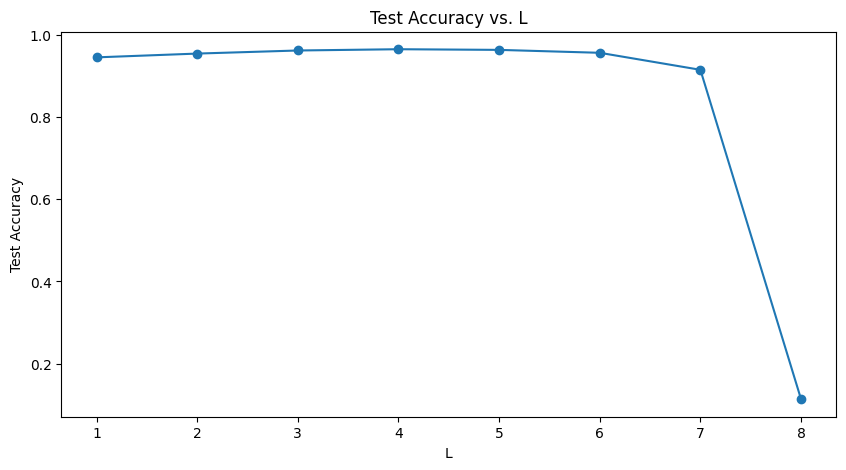

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(Ls, test_accs, 'o-')
plt.xlabel('L')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. L')
plt.show()

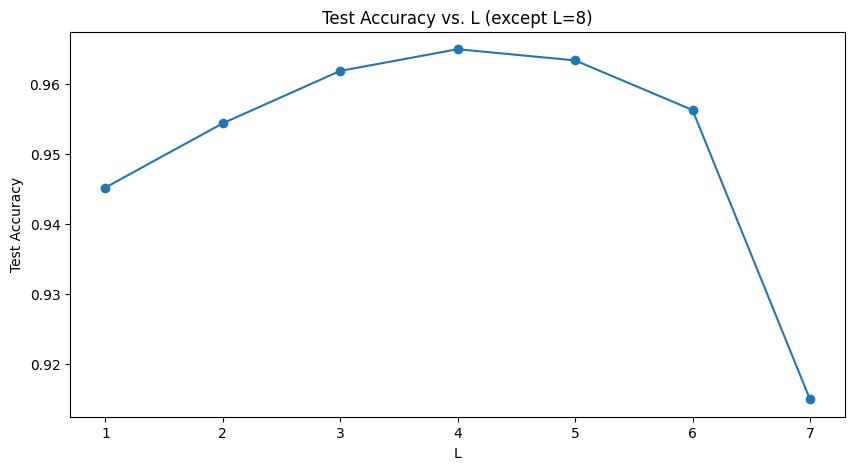

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(Ls[:-1], test_accs[:-1], 'o-')
plt.xlabel('L')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. L (except L=8)')
plt.show()